In [1]:
!pip install wordcloud tensorflow nltk seaborn joblib


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib



In [9]:
# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
file_path = "rct_data.txt"
with open(file_path, "r", encoding="utf-8") as f:
    data = f.readlines()

## Convert Data into a Pandas DataFrame

In [5]:
dataset = []
for line in data:
    parts = line.strip().split("\t")
    if len(parts) == 5:
        dataset.append(parts)

columns = ["PMID", "Label", "Year", "Title", "Abstract"]
df = pd.DataFrame(dataset, columns=columns)

df["Label"] = df["Label"].astype(int)
df["Year"] = df["Year"].astype(int)

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37967 entries, 0 to 37966
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PMID      37967 non-null  object
 1   Label     37967 non-null  int64 
 2   Year      37967 non-null  int64 
 3   Title     37967 non-null  object
 4   Abstract  37967 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.4+ MB
None
       PMID  Label  Year                                              Title  \
0  18439781      0  2011  Two patients subdued with a TASER® device: cas...   
1  18468833      0  2011  A case of Takayasu arteritis causing subclavia...   
2  18481181      0  2012  Pathophysiology of hypopituitarism in the sett...   
3  18728056      1  2011  The cardiovascular risk factor, soluble CD40 l...   
4  18790590      0  2011         Horner syndrome due to carotid dissection.   

                                            Abstract  
0  In the United States, an increasing nu

<ipython-input-6-a3c1afed9bbb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Label"], palette="pastel")


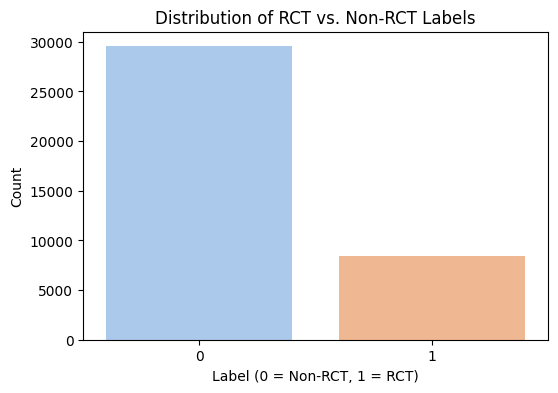

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Label"], palette="pastel")
plt.title("Distribution of RCT vs. Non-RCT Labels")
plt.xlabel("Label (0 = Non-RCT, 1 = RCT)")
plt.ylabel("Count")
plt.show()

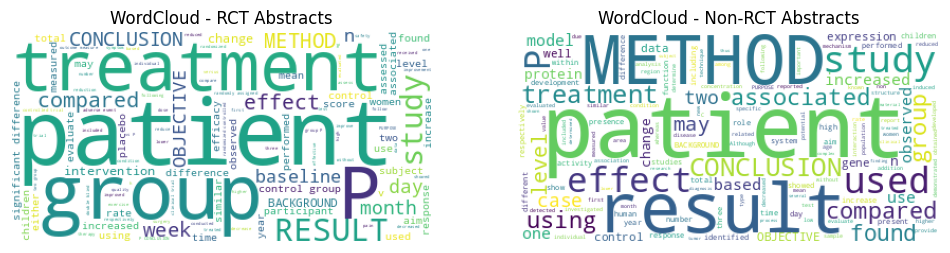

In [7]:
rct_text = " ".join(df[df["Label"] == 1]["Abstract"])
non_rct_text = " ".join(df[df["Label"] == 0]["Abstract"])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color="white").generate(rct_text))
plt.title("WordCloud - RCT Abstracts")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color="white").generate(non_rct_text))
plt.title("WordCloud - Non-RCT Abstracts")
plt.axis("off")

plt.show()

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans("", "", punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    return " ".join(words)

df["Cleaned_Abstract"] = df["Abstract"].apply(preprocess_text)
print(df[["Abstract", "Cleaned_Abstract"]].head())

                                            Abstract  \
0  In the United States, an increasing number of ...   
1  The American Heart Association website defines...   
2  The complex pathophysiology of traumatic brain...   
3  [BACKGROUND] Soluble CD40 ligand (sCD40L) is a...   
4  [BACKGROUND] Internal carotid artery dissectio...   

                                    Cleaned_Abstract  
0  united states increasing number law enforcemen...  
1  american heart association website defines syn...  
2  complex pathophysiology traumatic brain injury...  
3  background soluble cd ligand scdl powerful mar...  
4  background internal carotid artery dissection ...  


## Convert Text to TF-IDF Features

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["Cleaned_Abstract"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Size: {X_train.shape}, Testing Size: {X_test.shape}")

Training Size: (30373, 5000), Testing Size: (7594, 5000)


## Train Multiple ML Models

In [19]:
# Naïve Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naïve Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(classification_report(y_test, y_pred_nb))

Naïve Bayes Results:
Accuracy: 0.8960
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5909
           1       0.75      0.80      0.77      1685

    accuracy                           0.90      7594
   macro avg       0.84      0.86      0.85      7594
weighted avg       0.90      0.90      0.90      7594



In [14]:
# Logistic Regression
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
y_pred_lr = log_reg_model.predict(X_test)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
Accuracy: 0.9313
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5909
           1       0.90      0.78      0.83      1685

    accuracy                           0.93      7594
   macro avg       0.92      0.88      0.90      7594
weighted avg       0.93      0.93      0.93      7594



## CNN-based NLP Model

In [15]:
# Tokenize & Pad Sequences
MAX_WORDS = 5000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df["Cleaned_Abstract"])

X_seq = tokenizer.texts_to_sequences(df["Cleaned_Abstract"])
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN)

X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)

## Build CNN Model

In [17]:
cnn_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=100, input_length=MAX_LEN),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
cnn_model.fit(X_train_pad, y_train_pad, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test_pad))


Epoch 1/5
950/950 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - accuracy: 0.9506 - loss: 0.1369 - val_accuracy: 0.9439 - val_loss: 0.1592
Epoch 2/5
950/950 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step - accuracy: 0.9721 - loss: 0.0791 - val_accuracy: 0.9371 - val_loss: 0.1828
Epoch 3/5
950/950 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.9926 - loss: 0.0280 - val_accuracy: 0.9363 - val_loss: 0.2717
Epoch 4/5
950/950 ━━━━━━━━━━━━━━━━━━━━ 78s 81ms/step - accuracy: 0.9988 - loss: 0.0067 - val_accuracy: 0.9359 - val_loss: 0.3211
Epoch 5/5
950/950 ━━━━━━━━━━━━━━━━━━━━ 78s 78ms/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 0.9390 - val_loss: 0.4282


In [22]:
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_pad, y_test_pad)
print(f"CNN Model Accuracy: {cnn_acc:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9368 - loss: 0.4542
CNN Model Accuracy: 0.9390


<ipython-input-23-5f8c075e65dd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="coolwarm")


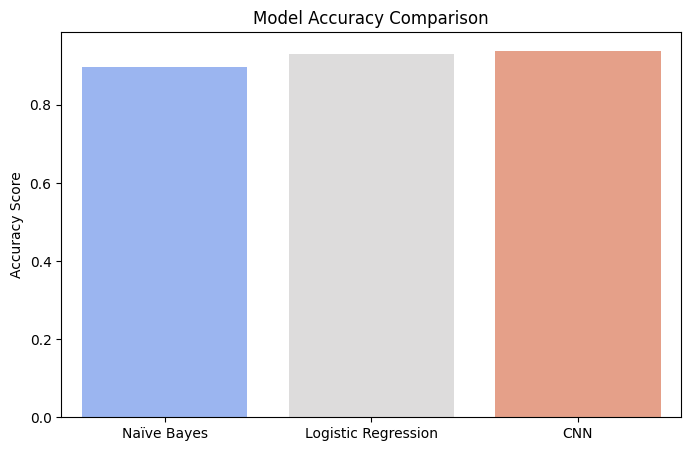

In [23]:
# Model Performance Visualization
models = ["Naïve Bayes", "Logistic Regression", "CNN"]
accuracies = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_lr),
    cnn_acc
]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette="coolwarm")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy Score")
plt.show()


238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


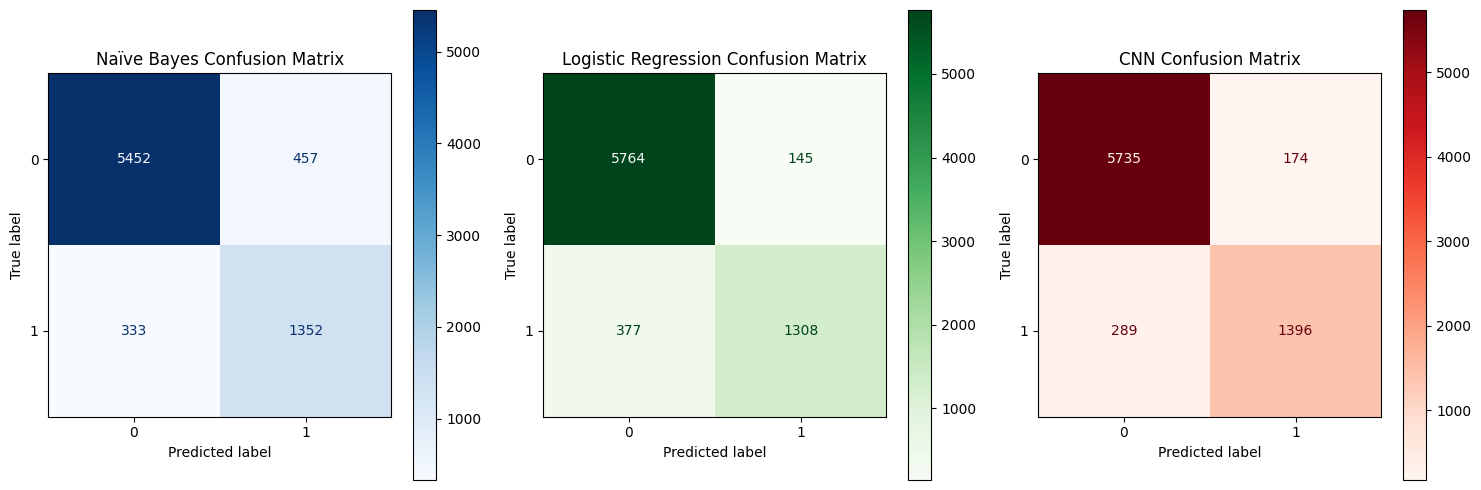

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

# Set figure size
plt.figure(figsize=(15, 5))

# Naïve Bayes Confusion Matrix
plt.subplot(1, 3, 1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, cmap="Blues", ax=plt.gca())
plt.title("Naïve Bayes Confusion Matrix")

# Logistic Regression Confusion Matrix
plt.subplot(1, 3, 2)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Greens", ax=plt.gca())
plt.title("Logistic Regression Confusion Matrix")

# CNN Confusion Matrix
plt.subplot(1, 3, 3)
y_pred_cnn = (cnn_model.predict(X_test_pad) > 0.5).astype("int32")  # Convert CNN predictions to binary labels
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cnn, cmap="Reds", ax=plt.gca())
plt.title("CNN Confusion Matrix")

plt.tight_layout()
plt.show()


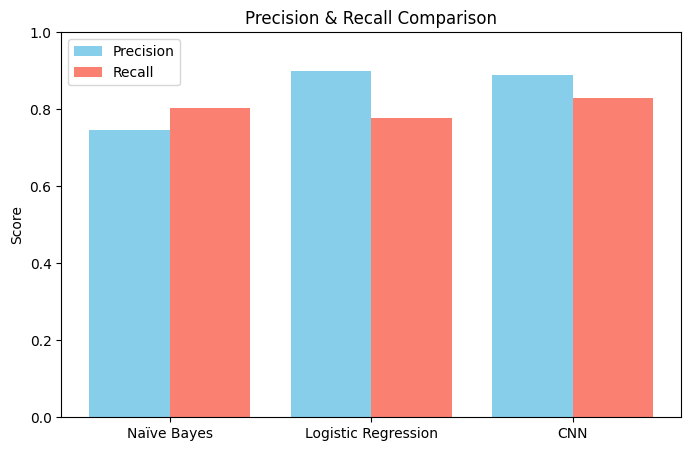

In [25]:
from sklearn.metrics import precision_score, recall_score

# Calculate Precision & Recall for each model
precision_scores = [
    precision_score(y_test, y_pred_nb),
    precision_score(y_test, y_pred_lr),
    precision_score(y_test, y_pred_cnn)
]

recall_scores = [
    recall_score(y_test, y_pred_nb),
    recall_score(y_test, y_pred_lr),
    recall_score(y_test, y_pred_cnn)
]

# Create bar plot for Precision & Recall
x_labels = ["Naïve Bayes", "Logistic Regression", "CNN"]
x = np.arange(len(x_labels))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, precision_scores, width=0.4, label="Precision", color="skyblue")
plt.bar(x + 0.2, recall_scores, width=0.4, label="Recall", color="salmon")

plt.xticks(x, x_labels)
plt.ylabel("Score")
plt.title("Precision & Recall Comparison")
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.legend()
plt.show()
